# IMPORT

In [0]:
import csv
import sys
import os, sys
import re
import string
import pathlib
import random
import nltk
import sklearn
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
seed = 42
np.random.seed = seed

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize


from collections import Counter, OrderedDict
import seaborn as sns
import spacy
from tqdm import tqdm, tqdm_notebook, tnrange
tqdm.pandas(desc='Progress')

from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torch.autograd import Variable

from sklearn.model_selection import StratifiedShuffleSplit, train_test_split
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity='all'

# stop word
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# stemmer
nltk.download('punkt')
ps = nltk.PorterStemmer()



[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# MANAGING FILES

In [0]:
# this functino is used to open csv or tsv as dataframe
# we should precise if the files are for training and id they are labelled.

def open_file(filename , training = True, label = True):
  
  if training:
    df = pd.read_csv(filename, sep='\t')
    
  else:
    if label:
      df = pd.read_csv(filename, sep='\t', names = ['tweet','subtask_a','subtask_b','subtask_c'])
    else: 
      df = pd.read_csv(filename, sep='\t')
    
  return df

df_ = open_file('offenseval-training-v1.tsv')
df_test = open_file('offenseval-trial.txt', training = False)
df_2 = open_file('testset-taska.tsv', training = False, label = False)
df_2.head(5)
df_.head(5)
df_test.head(5)

,id,tweet
0,15923,#WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...
1,27014,"#ConstitutionDay is revered by Conservatives, ..."
2,30530,#FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...
3,13876,#Watching #Boomer getting the news that she is...
4,60133,#NoPasaran: Unity demo to oppose the far-right...


,id,tweet,subtask_a,subtask_b,subtask_c
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN


,tweet,subtask_a,subtask_b,subtask_c
0,"@BreitbartNews OK Shannon, YOU tell the vetera...",NOT,NaN,NaN
1,@LeftyGlenn @jaredeker @BookUniverse @hashtagz...,NOT,NaN,NaN
2,Hot Mom Sucks Off Step Son In Shower 8 min htt...,OFF,UNT,NaN
3,bro these are some cute butt plugs I’m trying ...,OFF,UNT,NaN
4,Arizona Supreme Court strikes down state legis...,NOT,NaN,NaN


In [0]:
def get_tweet(data, position):
  return data.tweet.iloc[position]

get_tweet(df_,7)

# DATA AUGMENTATION

In [0]:
with open('offenseval-training-v1.tsv') as tsvfile:
  reader = csv.reader(tsvfile, delimiter='\t')
  file = []
  for row in reader:
    file.append(row)

In [0]:
def tokenize(text):
    tokenized =  nltk.sent_tokenize(text)
    return tokenized
	

		
def shuffle_tokenized(text,shuffled):
    np.random.shuffle(text)
    newl=list(text)
    shuffled.append(newl)
    return text

In [0]:
## DATA AUGMENTATION FOR TASK A

def data_augmentation(file, n=3):

  files = np.array(file)
  neg_files = files[files[:,2]=='OFF']
  neg_files = neg_files[:,1]
  pos_files = files[files[:,2]=='NOT']
  pos_files = pos_files[:,1:3]



  augmented = []
  reps=[]
  for ng_rev in neg_files:
    tok = tokenize(ng_rev)
    shuffled= [tok]
    #print(shuffled)
    for i in range(n):
      #generate n new reviews
      shuffle_tokenized(shuffled[-1],shuffled)
      
    for k in shuffled:
    #'''create new tweet by joining the shuffled sentences'''
        s = ' '
        new_rev = s.join(k)
        if new_rev not in augmented:
            augmented.append(new_rev)
        else:
            reps.append(new_rev)



  off = np.array(['OFF' for i in range(len(augmented))])
  augmented = np.array(augmented)
  A = np.concatenate((augmented.reshape(-1,1), off.reshape(-1,1)), axis=1)
  B = np.concatenate((pos_files,A),axis=0)
  df_a = pd.DataFrame(B)
  df_a.columns = ['tweet', 'subtask_a']
  df_a = df_a.sample(frac=1)
  return df_a

In [0]:
## DATA AUGMENTATION FOR TASK B

def data_augmentation_b(file, n=70):

  
  files = np.array(file)
  off_files = files[files[:,2]=='OFF']
  unt_files = off_files[off_files[:,3]=='UNT']
  unt_files = unt_files[:,1]
  pos_files = off_files[off_files[:,3]=='TIN']
  pos_files = pos_files[:,1:4:2]



  augmented = []
  reps=[]
  for ng_rev in unt_files:
    tok = tokenize(ng_rev)
    shuffled= [tok]
    #print(shuffled)
    for i in range(n):
      #generate n new reviews
      shuffle_tokenized(shuffled[-1],shuffled)
      
    for k in shuffled:
    #'''create new tweet by joining the shuffled sentences'''
        s = ' '
        new_rev = s.join(k)
        if new_rev not in augmented:
            augmented.append(new_rev)
        else:
            reps.append(new_rev)



  unt = np.array(['UNT' for i in range(len(augmented))])
  augmented = np.array(augmented)
  A = np.concatenate((augmented.reshape(-1,1), unt.reshape(-1,1)), axis=1)
  B = np.concatenate((pos_files,A),axis=0)
  df_a = pd.DataFrame(B)
  df_a.columns = ['tweet', 'subtask_b']
  df_a = df_a.sample(frac=1)
  return df_a

#df_b = data_augmentation_b(file,70)

In [0]:
## DATA AUGMENTATION FOR TASK C

def data_augmentation_c(file, n=30,m=4):

  files = np.array(file)
  off_files = files[files[:,2]=='OFF']
  oth_files = off_files[off_files[:,4]=='OTH']
  oth_files = oth_files[:,1]
  grp_files = off_files[off_files[:,4]=='GRP']
  grp_files = grp_files[:,1]
  ind_files = off_files[off_files[:,4]=='IND']
  ind_files = ind_files[:,1:5:3]


  augmented1 = []
  reps1=[]
  augmented2 = []
  reps2=[]
  for ng_rev in oth_files:
    #print(ng_rev)
    tok = tokenize(ng_rev)
    shuffled= [tok]
    #print(shuffled)
    for i in range(n):
      #generate n new reviews
      shuffle_tokenized(shuffled[-1],shuffled)
      
    for k in shuffled:
    #'''create new tweet by joining the shuffled sentences'''
        s = ' '
        new_rev = s.join(k)
        if new_rev not in augmented1:
            augmented1.append(new_rev)
        else:
            reps1.append(new_rev)
    
            
            
  for ng_rev in grp_files:
    tok = tokenize(ng_rev)
    shuffled= [tok]
    #print(shuffled)
    for i in range(m):
      #generate n new reviews
      shuffle_tokenized(shuffled[-1],shuffled)

    for k in shuffled:
    #'''create new tweet by joining the shuffled sentences'''
        s = ' '
        new_rev = s.join(k)
        if new_rev not in augmented2:
            augmented2.append(new_rev)
        else:
            reps2.append(new_rev)


  oth = np.array(['OTH' for i in range(len(augmented1))])
  grp = np.array(['GRP' for i in range(len(augmented2))])
  augmented1 = np.array(augmented1)
  augmented2 = np.array(augmented2)
  A1 = np.concatenate((augmented1.reshape(-1,1), oth.reshape(-1,1)), axis=1)
  A2 = np.concatenate((augmented2.reshape(-1,1), grp.reshape(-1,1)), axis=1)
  B1 = np.concatenate((ind_files,A1),axis=0)
  B2 = np.concatenate((B1,A2),axis=0)
  df_a = pd.DataFrame(B2)
  df_a.columns = ['tweet', 'subtask_c']
  df_a = df_a.sample(frac=1)
  return df_a

# PREPROCESSING THE DATA

** all the following functions will be used to get the data and preprocess them **

Preprocessing the data with common transformations. We explained in detail those transformations in the report. 

In [0]:
def preprocessing_data(df , training = True, label= True, subtask = 'a'):
  
  encoder = LabelEncoder()
  
  ## SENTIMENT CLASSIFICATION ##
  if label:
    if subtask == 'a':
      df['sentiment_class'] = encoder.fit_transform(df.subtask_a)
    elif subtask == 'b':
      df['sentiment_class'] = encoder.fit_transform(df.subtask_b)
    else:
      df['sentiment_class'] = encoder.fit_transform(df.subtask_c)
  
  # replace @name => user
  df['tweet_processed'] = df.tweet.str.replace(r'@([A-Za-z0-9_]+)', ' @user ')
  # replace # => hashtag
  #df['tweet_processed'] = df.tweet_processed.str.replace(r'#([A-Za-z0-9_]+)', ' hashtag ')
  # replace https => url
  df['tweet_processed'] = df.tweet_processed.str.replace(r' (https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9]\.[^\s]{2,})', ' url ')

  if training:
    
    #caractere spéciaux 
    df['tweet_processed'] = df.tweet_processed.str.replace(r'[^\w\d\s!]',' ')
    df['tweet_processed'] = df.tweet_processed.str.lower()
    print(1)
    
  else :
    
    df['tweet_processed'] = df.tweet_processed.str.replace(r'[^\w\d\s]',' ')
    df['tweet_processed'] = df.tweet_processed.str.lower()
    print(2)
    
  df['tweet_processed'] = df.tweet_processed.str.replace(r'[^!]![^!]',' !')
  df['tweet_processed'] = df.tweet_processed.str.replace(r'[^!]!![^!]',' !!')
  df['tweet_processed'] = df.tweet_processed.str.replace(r'!!!+',' !!! ')

  df['tweet_processed'] = df.tweet_processed.str.replace(r' [A-Za-z] ', ' ')
  #df['tweet_processed'] = df.tweet_processed.str.replace(r' user ', ' ')
  #df['tweet_processed'] = df.tweet_processed.str.replace(r'url', ' ')
  df['tweet_processed'] = df.tweet_processed.apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words)) 
  df['tweet_processed'] = df.tweet_processed.apply(lambda x: ' '.join(ps.stem(term) for term in x.split()))
  
  return df

df_processed_ = preprocessing_data(df_, training = True)
df_processed_.head(5)
print(df_processed_.iloc[1]['tweet_processed'])

df_processed_test = preprocessing_data(df_test, training = False)
df_processed_test.head(5)


1


,id,tweet,subtask_a,subtask_b,subtask_c,sentiment_class,tweet_processed
0,86426,@USER She should ask a few native Americans wh...,OFF,UNT,NaN,1,user ask nativ american take
1,90194,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF,TIN,IND,1,user user go home drunk !!! user maga trump202...
2,16820,Amazon is investigating Chinese employees who ...,NOT,NaN,NaN,0,amazon investig chines employe sell intern dat...
3,62688,"@USER Someone should'veTaken"" this piece of sh...",OFF,UNT,NaN,1,user someon vetaken piec shit volcano
4,43605,@USER @USER Obama wanted liberals &amp; illega...,NOT,NaN,NaN,0,user user obama want liber amp illeg move red ...


user user go home drunk !!! user maga trump2020 url
2


,tweet,subtask_a,subtask_b,subtask_c,sentiment_class,tweet_processed
0,"@BreitbartNews OK Shannon, YOU tell the vetera...",NOT,NaN,NaN,0,user ok shannon tell veteran locker room stay ...
1,@LeftyGlenn @jaredeker @BookUniverse @hashtagz...,NOT,NaN,NaN,0,user user user user user user fine could affor...
2,Hot Mom Sucks Off Step Son In Shower 8 min htt...,OFF,UNT,NaN,1,hot mom suck step son shower 8 min url
3,bro these are some cute butt plugs I’m trying ...,OFF,UNT,NaN,1,bro cute butt plug tri cop url
4,Arizona Supreme Court strikes down state legis...,NOT,NaN,NaN,0,arizona suprem court strike state legisl prohi...


Get Dictionnary of words

In [0]:
def get_dictionnary(df):

  # DICTIONNARY OF WORDS
  all_words_processed = []
  for tweet in df['tweet_processed']:
    words = word_tokenize(tweet)
    for w in words:
      all_words_processed.append(w)

  return nltk.FreqDist(all_words_processed)


#all_words_processed_ = get_dictionnary(df_processed_)


Get most common words 

In [0]:
def most_common_words(nbr, dictionnary):
  return [dictionnary.most_common(nbr)[i][0] for i in range(nbr)]

#words_common_ = most_common_words(3000,all_words_processed_)


Preprocessing the data keeping only most common words

In [0]:
def preprocessing_most_common_words(df, words_common, label):
  df['tweet_processed'] = df.tweet_processed.apply(lambda x:  ' '.join(item for item in x.split() if item in words_common))
  
  # remove empty cells
  if label == False:
    print(df[df['tweet_processed'] == '']['id'])
  df['tweet_processed'].replace('', np.nan, inplace=True)
  df.dropna(subset=['tweet_processed'], inplace=True)

  return df


Construct a mapping from words to indexes and vice versa

In [0]:
def create_mapping(words_common):
  
  # get only words from dictionnary after preprocessing 
  words_processed = sorted(words_common,  reverse=True)

  print("Number of words after preprocessing: {}\n".format(len(words_processed)))

  word2idx = {o:i for i,o in enumerate(words_processed)}
  idx2word = {i:o for i,o in enumerate(words_processed)}
  
  return word2idx , idx2word

#word2idx , idx2word = create_mapping(words_common)

Indexing the words for neural network use

In [0]:
def indexer(tweet):
  return [word2idx[w.lower()] for w in word_tokenize(tweet)]

def apply_indexing(df):
  df['tweetidx'] = df.tweet_processed.apply(indexer)
  df['lenght'] = df.tweetidx.apply(len)
  return df
  

# GET DATA

This is an example on how to get the data. For the following part, the data are loaded again at the beggining of each part. 

In [0]:
def get_data_processed(filename , nbr_common_words , training = True , label = True ):
  
  # opening
  df = open_file(filename, training , label)
    
  if training:
    
    # data_augmentation
    df_a = data_augmentation(file, 2)
    
    # common preprocessing
    df_processed = preprocessing_data(df_a, training, label)
    
    # get dictionnary 
    all_words_processed = get_dictionnary(df_processed)

    # get common words
    words_common = most_common_words(nbr_common_words ,all_words_processed)

    # processed common words
    df_processed = preprocessing_most_common_words(df_processed, words_common, label)

    # create mapping
    word2idx , idx2word = create_mapping(words_common)  

    return df_processed , word2idx, idx2word , words_common

  
  else:
    
    # common preprocessing
    df_processed = preprocessing_data(df, training, label)
    
    return df_processed
  
  
  

In [0]:
nbr_words =3000

df_processed , word2idx, idx2word, words_common = get_data_processed (filename = 'offenseval-training-v1.tsv' , nbr_common_words = nbr_words , training = True)

df_ =  apply_indexing(df_processed)

df_.head(5)

# DATA ANALYSIS

GRP    3429
OTH    2572
IND    2407
Name: subtask_c, dtype: int64


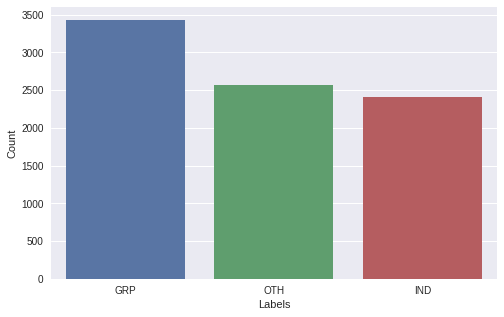

In [0]:
def data_analysis(df):
  
  print(df.subtask_c.value_counts())
  
  Dfig = plt.figure(figsize=(8,5))
  ax = sns.barplot(x=[df.subtask_c.unique()[2],df.subtask_c.unique()[1], df.subtask_c.unique()[0]],y=df.subtask_c.value_counts());
  ax.set(xlabel='Labels' )
  ax.set(ylabel='Count')

data_analysis(df_c)

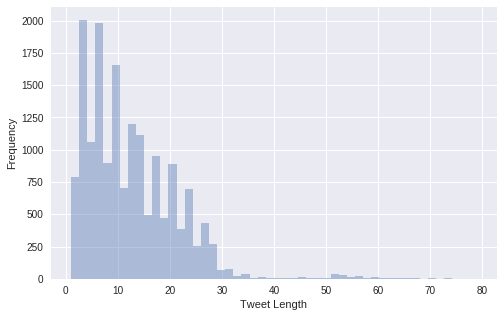

In [0]:
fig = plt.figure(figsize=(8,5))
ax = sns.distplot(df_.lenght.values,kde=False);
ax.set(xlabel='Tweet Length', ylabel='Frequency');

# Classification : Scikit-Learn and NLTK

In [0]:
with open('offenseval-training-v1.tsv') as tsvfile:
  reader = csv.reader(tsvfile, delimiter='\t')
  file = []
  for row in reader:
    file.append(row)

        
df = pd.DataFrame.from_csv('offenseval-training-v1.tsv', sep='\t')
classes= df['subtask_a']
tweets = df['tweet']

In [0]:
from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn import model_selection


encoder = LabelEncoder()
Y = encoder.fit_transform(classes)

print(classes[:10])
print(Y[:10])

tweets_processed = tweets.str.replace(r'[^\w\d\s]',' ')
tweets_processed = tweets_processed.str.lower()

nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
tweet_processed = tweets_processed.apply(lambda x: ' '.join(term for term in x.split() if term not in stop_words))
tweets_processed = tweets_processed.str.replace(r'@{1}([a-zA-Z0-9]{1,15}) ', 'user')
tweets_processed = tweets_processed.str.replace(r' [A-Za-z] ', ' ')
ps = nltk.PorterStemmer()

tweets_processed = tweets_processed.apply(lambda x: ' '.join(ps.stem(term) for term in x.split()))

nltk.download('punkt')

# creating a bag of word

all_words = []


for tweet in tweets_processed:
  words = word_tokenize(tweet)
  for w in words:
    all_words.append(w)

all_words = nltk.FreqDist(all_words)

word_features = [all_words.most_common(3000)[i][0] for i in range(3000)]

id
86426    OFF
90194    OFF
16820    NOT
62688    OFF
43605    NOT
97670    OFF
77444    OFF
52415    OFF
45157    NOT
13384    OFF
Name: subtask_a, dtype: object
[1 1 0 1 0 1 1 1 0 1]
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Feature extraction

In [0]:
def find_features(tweet):
  words = word_tokenize(tweet)
  features = {}
  for w in word_features:
    features[w] = (w in words)
  
  return features

In [0]:
#feature extraction
seed = 42
np.random.seed = seed

tw = list(zip(tweets_processed,Y))

 
np.random.shuffle(tw)
featuresets = [(find_features(text),label) for (text,label) in tw ]
training, testing = model_selection.train_test_split(featuresets, test_size = 0.1, random_state = seed)
print("Training: {}".format(len(training)))
  
print("Testing: {}".format(len(testing)))

Training: 11916
Testing: 1324


Building classifiers

In [0]:
#imports from sklearn classifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix



DEFINING THE MODELS TO TRAIN

In [0]:
names = ['KNeighborsClassifier', 'DecisionTreeClassifier','RandomForestClassifier',
         'LogisticRegression', 'SGDClassifier', 'Naive Bayes', 'SVM Linear']
classifiers = [
    KNeighborsClassifier(), 
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    LogisticRegression(), 
    SGDClassifier(max_iter = 100), 
    MultinomialNB(), 
    SVC(kernel='linear')
]

models = list(zip(names,classifiers))
print(models)

[('KNeighborsClassifier', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')), ('DecisionTreeClassifier', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')), ('RandomForestClassifier', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
 

In [0]:
from nltk.classify.scikitlearn import SklearnClassifier

for name, model in models:
  nltk_model = SklearnClassifier(model)
  nltk_model.train(training)
  accuracy = nltk.classify.accuracy(nltk_model,testing)*100
  print("The model accuracy for {} classifier is {}".format(name,accuracy))

<SklearnClassifier(KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform'))>

The model accuracy for KNeighborsClassifier classifier is 71.22356495468279


<SklearnClassifier(DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'))>

The model accuracy for DecisionTreeClassifier classifier is 71.67673716012085


<SklearnClassifier(RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))>

The model accuracy for RandomForestClassifier classifier is 75.52870090634441


<SklearnClassifier(LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))>

The model accuracy for LogisticRegression classifier is 76.81268882175226


<SklearnClassifier(SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=100,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False))>

The model accuracy for SGDClassifier classifier is 76.81268882175226


<SklearnClassifier(MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True))>

The model accuracy for Naive Bayes classifier is 76.13293051359517


<SklearnClassifier(SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='linear', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))>

The model accuracy for SVM Linear classifier is 76.73716012084593


VOTING CLASSIFER 

In [0]:
from sklearn.ensemble import VotingClassifier

names = ['KNeighborsClassifier', 'DecisionTreeClassifier','RandomForestClassifier',
         'LogisticRegression', 'SGDClassifier', 'Naive Bayes', 'SVM Linear'] 

classifiers = [
    KNeighborsClassifier(), 
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    LogisticRegression(), 
    SGDClassifier(max_iter = 100), 
    MultinomialNB(), 
    SVC(kernel='linear')
]

models = list(zip(names,classifiers))

# ensemble method 

nltk_ensemble = SklearnClassifier(VotingClassifier(estimators = models,voting='hard',n_jobs =-1))
nltk_ensemble.train(training)
accuracy = nltk.classify.accuracy(nltk_ensemble,testing)*100
print('Ensemble method accuracy: {}'.format(accuracy))

<SklearnClassifier(VotingClassifier(estimators=[('KNeighborsClassifier', KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='uniform')), ('DecisionTreeClassifier', DecisionTreeClassifier(class_weight=None, criterion='gini', max_dep...r', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False))],
         flatten_transform=None, n_jobs=-1, voting='hard', weights=None))>

Ensemble method accuracy: 76.58610271903324


ANALYZING PREDICTIONS

In [0]:
#prediction 
txt_features, labels = zip(*testing)

prediction =  nltk_ensemble.classify_many(txt_features)
print('accuracy score:',accuracy_score(labels,prediction))
print( classification_report(labels,prediction))

pd.DataFrame(
confusion_matrix(labels, prediction),
index = [['actual', 'actual'],['NOT','OFF']],
columns = [['predicted','predicted'],['NOT','OFF']] )

accuracy score: 0.7658610271903323
              precision    recall  f1-score   support

           0       0.79      0.90      0.84       904
           1       0.69      0.48      0.57       420

   micro avg       0.77      0.77      0.77      1324
   macro avg       0.74      0.69      0.70      1324
weighted avg       0.76      0.77      0.75      1324



predicted     
                 NOT  OFF
actual NOT       812   92
       OFF       218  202

# NEURAL NETWORK

## PADDING, FITTING

We used the class Vectorize Data to create from the preprocessed tweets a vectorised version, than will be load into the neural network.

In [0]:
class VectorizeData(Dataset):
    def __init__(self, df, maxlen):
      
        self.maxlen = maxlen
              
        self.df = df
        
        ## LENGTH
        print('Calculating lengths')
        self.df['lengths'] = self.df.tweetidx.progress_apply(lambda x: self.maxlen if len(x) > self.maxlen else len(x))
        
        ## PADDING
        
        print('Padding')
        self.df['tweetpadded'] = self.df.tweetidx.progress_apply(self.pad_data)
        
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        X = self.df.tweetpadded.iloc[idx]
        lens = self.df.lengths.iloc[idx]
        y = self.df.sentiment_class.iloc[idx]
        return X,y,lens
    
    def pad_data(self, s):
        padded = np.zeros((self.maxlen,), dtype=np.int64)
        #padded = np.arange(3000,self.maxlen+3000, 1)

        if len(s) > self.maxlen: padded[:] = s[:self.maxlen]
        else: padded[:len(s)] = s
        return padded
      


Function to sort the batch according to tweet lengths, used in the fitting part. 


In [0]:
def sort_batch(X, y, lengths):
    lengths, indx = lengths.sort(dim=0, descending=True)
    X = X[indx]
    y = y[indx]
    return X.transpose(0,1), y, lengths # transpose (batch x seq) to (seq x batch)

In [0]:
def fit(model, train_dl, val_dl, loss_fn, opt, epochs=10):
  
    num_batch = len(train_dl)
    print(num_batch)
    
    for epoch in tnrange(epochs):      
        y_true_train = list()
        y_pred_train = list()
        total_loss_train = 0
        
        if val_dl:
            y_true_val = list()
            y_pred_val = list()
            total_loss_val = 0
        
        t = tqdm_notebook(iter(train_dl), leave=False, total=num_batch)
        
        for X,y, lengths in t:
          
            t.set_description(f'Epoch {epoch}')
            X,y,lengths = sort_batch(X,y,lengths)
            X = Variable(X.cuda())
            y = Variable(y.cuda())
            lengths = lengths.numpy()
            
            opt.zero_grad()
            pred = model(X, lengths, gpu=True)
            loss = loss_fn(pred, y)
            loss.backward()
            opt.step()
            
            t.set_postfix(loss=loss.item())
            pred_idx = torch.max(pred, dim=1)[1]
            
            y_true_train += list(y.cpu().detach().numpy())
            y_pred_train += list(pred_idx.cpu().detach().numpy())
            total_loss_train += loss.item()
            
        train_acc = accuracy_score(y_true_train, y_pred_train)
        train_loss = total_loss_train/len(train_dl)
        print(f' Epoch {epoch}: Train loss: {train_loss} acc: {train_acc}')
        
        if val_dl:
            for X,y,lengths in tqdm_notebook(val_dl, leave=False):
                X, y,lengths = sort_batch(X,y,lengths)
                X = Variable(X.cuda())
                y = Variable(y.cuda())
                pred = model(X, lengths.numpy())
                loss = loss_fn(pred, y)
                
                pred_idx = torch.max(pred, 1)[1]
                y_true_val += list(y.cpu().detach().numpy())
                y_pred_val += list(pred_idx.cpu().detach().numpy())
                total_loss_val += loss.item()
            valacc = accuracy_score(y_true_val, y_pred_val)
            valloss = total_loss_val/len(val_dl)
            print(f'Val loss: {valloss} acc: {valacc}')
    return y_pred_val,y_true_val


In [0]:
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

cuda:0


## CONCAT MAX/AVE POOLING GRU

This is the model that we used  for the GRU architecture of our classifier. We used dropout in the GRU part,  to prevent from overfitting.

In [0]:
class ConcatPoolingGRUAdaptive(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_hidden, n_out):
        super().__init__()
        
        self.vocab_size,self.embedding_dim,self.n_hidden,self.n_out = vocab_size, embedding_dim, n_hidden, n_out
        self.emb = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.gru = nn.GRU(self.embedding_dim, self.n_hidden, dropout= 0.5)
        self.out = nn.Linear(self.n_hidden*3, self.n_out)
        
    def forward(self, seq, lengths, gpu=True):
      
        self.h = self.init_hidden(seq.size(1), gpu)
        embs = self.emb(seq)
        embs = pack_padded_sequence(embs, lengths)
        gru_out, self.h = self.gru(embs, self.h)
        gru_out, lengths = pad_packed_sequence(gru_out)        
        
        avg_pool = F.adaptive_avg_pool1d(gru_out.permute(1,2,0),1).view(seq.size(1),-1)
        max_pool = F.adaptive_max_pool1d(gru_out.permute(1,2,0),1).view(seq.size(1),-1)

        outp = self.out(torch.cat([self.h[-1],avg_pool,max_pool],dim=1))             
        return F.log_softmax(outp, dim=-1)
    
    def init_hidden(self, batch_size, gpu):
        if gpu: return Variable(torch.zeros((1,batch_size,self.n_hidden)).cuda())
        else: return Variable(torch.zeros((1,batch_size,self.n_hidden)))

# TRAINING PART

In [0]:
GPU = True
device_idx = 0
if GPU:
    device = torch.device("cuda:" + str(device_idx) if torch.cuda.is_available() else "cpu")
else:
    device = torch.device("cpu")
print(device)

cuda:0


## TASK A

PARAMETERS

In [0]:
maxlen = 14
nbr_words =3000
vocab_size = nbr_words
embedding_dim = 10
n_hidden = 5
n_out = 2

GETTING THE DATA

In [0]:
df_processed , word2idx, idx2word, words_common = get_data_processed (filename = 'offenseval-training-v1.tsv' , 
                                                                      nbr_common_words = nbr_words , training = True, label = True)

df_ =  apply_indexing(df_processed)

df_.head(5)

1
Number of words after preprocessing: 5000



,tweet,subtask_a,sentiment_class,tweet_processed,tweetidx,lenght
13237,He has dodgy financials. He is too extreme for...,OFF,1,financi extrem sc commit perjuri think contrac...,"[3235, 3341, 1141, 4039, 1692, 552, 3954, 4880...",16
10872,@USER The washed-out idiot #Biden feels he has...,OFF,1,user wash idiot biden feel chanc insult conser...,"[292, 187, 2748, 4462, 3270, 4186, 2648, 3978,...",14
3508,@USER @USER @USER He is an incredible leader a...,NOT,0,user user user incred leader true hero thank user,"[292, 292, 292, 2694, 2412, 405, 2871, 581, 292]",9
7442,#boom @USER maybe that book deal isnt such a g...,NOT,0,boom user mayb book deal isnt good idea maga q...,"[4387, 292, 2196, 4389, 3795, 2600, 3029, 2754...",15
6485,@USER 10 cities with a total of 30 people atte...,NOT,0,user 10 citi total 30 peopl attend,"[292, 4993, 4117, 475, 4936, 1706, 4627]",7


Vectorising the data

In [0]:
ds_a = VectorizeData(df_, maxlen)

df_.head(5)

Progress:   0%|          | 0/15137 [00:00<?, ?it/s]

Calculating lengths
Padding


Progress: 100%|██████████| 15137/15137 [00:00<00:00, 194291.98it/s]


,tweet,subtask_a,sentiment_class,tweet_processed,tweetidx,lenght,lengths,tweetpadded
13237,He has dodgy financials. He is too extreme for...,OFF,1,financi extrem sc commit perjuri think contrac...,"[3235, 3341, 1141, 4039, 1692, 552, 3954, 4880...",16,14,"[3235, 3341, 1141, 4039, 1692, 552, 3954, 4880..."
10872,@USER The washed-out idiot #Biden feels he has...,OFF,1,user wash idiot biden feel chanc insult conser...,"[292, 187, 2748, 4462, 3270, 4186, 2648, 3978,...",14,14,"[292, 187, 2748, 4462, 3270, 4186, 2648, 3978,..."
3508,@USER @USER @USER He is an incredible leader a...,NOT,0,user user user incred leader true hero thank user,"[292, 292, 292, 2694, 2412, 405, 2871, 581, 292]",9,9,"[292, 292, 292, 2694, 2412, 405, 2871, 581, 29..."
7442,#boom @USER maybe that book deal isnt such a g...,NOT,0,boom user mayb book deal isnt good idea maga q...,"[4387, 292, 2196, 4389, 3795, 2600, 3029, 2754...",15,14,"[4387, 292, 2196, 4389, 3795, 2600, 3029, 2754..."
6485,@USER 10 cities with a total of 30 people atte...,NOT,0,user 10 citi total 30 peopl attend,"[292, 4993, 4117, 475, 4936, 1706, 4627]",7,7,"[292, 4993, 4117, 475, 4936, 1706, 4627, 0, 0,..."


SPLITTING TRAIN-TEST

In [0]:
training_a, validation_a = model_selection.train_test_split(ds_a, test_size = 0.1, random_state = seed)

print("Shape training test:{} and testing test:{}".format(len(training_a), len(validation_a)))

Shape training test:13623 and testing test:1514


TRAINING

In [0]:
seed = 42
torch.manual_seed(seed)


train_dl_a = DataLoader(training_a, batch_size=128)
val_dl_a = DataLoader(validation_a, batch_size=128)

model_a = ConcatPoolingGRUAdaptive(vocab_size, embedding_dim, n_hidden, n_out).cuda()
opt = optim.Adam(model_a.parameters(), lr =1e-2, weight_decay=1e-4)

y_true_val_a, y_pred_val_a = fit(model=model_a, train_dl=train_dl_a, val_dl=val_dl_a, loss_fn=F.nll_loss, opt=opt, epochs=10)

107


 Epoch 0: Train loss: 0.6302490200951835 acc: 0.6510878323932313


Val loss: 0.5746827671925226 acc: 0.7270929466051417


 Epoch 1: Train loss: 0.5293983193201439 acc: 0.7631675335140283


Val loss: 0.5188631589214007 acc: 0.7626895187870798


 Epoch 2: Train loss: 0.4602690188684196 acc: 0.8014064903670061


Val loss: 0.4676157558957736 acc: 0.8048780487804879


 Epoch 3: Train loss: 0.3980745127267927 acc: 0.8367152589553879


Val loss: 0.4572189226746559 acc: 0.8108108108108109


 Epoch 4: Train loss: 0.36200338295687023 acc: 0.8505603985056039


Val loss: 0.45652833580970764 acc: 0.7989452867501649


 Epoch 5: Train loss: 0.3379330433139177 acc: 0.8640392645227456


Val loss: 0.47128703196843463 acc: 0.7936717205009888


 Epoch 6: Train loss: 0.32141424813003183 acc: 0.8693868581056333


Val loss: 0.48596203823884326 acc: 0.7963085036255768


 Epoch 7: Train loss: 0.3015827610392437 acc: 0.8793494982052596


Val loss: 0.5066275149583817 acc: 0.7903757415952538


 Epoch 8: Train loss: 0.2868614663309026 acc: 0.8859424218006007


Val loss: 0.5214127351840337 acc: 0.7818061964403428


 Epoch 9: Train loss: 0.26778140608395373 acc: 0.8968573730862208


Val loss: 0.5382425710558891 acc: 0.7857613711272248



METRICS

In [0]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

pd.DataFrame(
confusion_matrix(y_true_val_a, y_pred_val_a),
index = [['actual','actual'],[ 'NOT','OFF']],
columns = [['predicted','predicted'],['NOT','OFF']] )

print('Classification report:')
print( classification_report(y_true_val_a,y_pred_val_a))

print( 'Accuracy score :' ,accuracy_score(y_true_val_a,y_pred_val_a))

predicted     
                 NOT  OFF
actual NOT       689  138
       OFF       187  503

Classification report:
              precision    recall  f1-score   support

           0       0.79      0.83      0.81       827
           1       0.78      0.73      0.76       690

   micro avg       0.79      0.79      0.79      1517
   macro avg       0.79      0.78      0.78      1517
weighted avg       0.79      0.79      0.78      1517

Accuracy score : 0.7857613711272248


## TASK B

In [0]:
def extract_b(df):
  
  df = df[df['subtask_a']== 'OFF']
  return df

def get_data_processed_b(filename , nbr_common_words , subtask , training = True , label = True ):
  
  # opening
  df = open_file(filename, training , label)
  
  df = extract_b(df)
  
  df[df.subtask_b == 'TTH'] = 'TIN'

    
  if training:
    
    df_b = data_augmentation_b(file, 90)

    # common preprocessing
    df_processed = preprocessing_data(df_b, training, label, subtask)
    
    # get dictionnary 
    all_words_processed = get_dictionnary(df_processed)
    
    # get common words
    words_common = most_common_words(nbr_common_words ,all_words_processed)

    # processed common words
    df_processed = preprocessing_most_common_words(df_processed, words_common, label)

    # create mapping
    word2idx , idx2word = create_mapping(words_common)  

    return df_processed , word2idx, idx2word , words_common

  
  else:
    
    # common preprocessing
    df_processed = preprocessing_data(df, training, label, subtask)
    
    return df_processed
  

PARAMETERS

In [0]:
maxlen = 14
nbr_words =3000
vocab_size = nbr_words
embedding_dim = 10 
n_hidden = 5
n_out = 2

GETTING THE DATA

In [0]:
df_processed_b , word2idx, idx2word, words_common = get_data_processed_b(filename = 'offenseval-training-v1.tsv' , nbr_common_words = nbr_words , 
                                                                       subtask = 'b' ,training = True, label = True)

df_b =  apply_indexing(df_processed_b)

df_b.head(5)

1
Number of words after preprocessing: 5000



,tweet,subtask_b,sentiment_class,tweet_processed,tweetidx,lenght
3600,@USER @USER She is a 🤡,TIN,0,user user,"[312, 312]",2
1534,@USER Look at how shamelessly liberals lie to ...,TIN,0,user look shamelessli liber lie destroy man life,"[312, 2319, 1072, 2382, 2371, 3739, 2257, 2368]",8
5076,But it’s your life do ur thing haha. Shit happ...,UNT,1,life ur thing haha shit happen everyon mindset...,"[2368, 319, 568, 2971, 1054, 2953, 3417, 2132,...",28
3118,@USER @USER You’re in embarrassment to the Rep...,TIN,0,user user embarrass republican part took cowar...,"[312, 312, 3500, 1329, 1769, 507, 3940, 194]",8
4779,Makes their statements regarding gun control s...,UNT,1,make statement regard gun control stupi ! user...,"[2263, 818, 1368, 2985, 3996, 754, 4999, 312, ...",16


In [0]:
ds_b = VectorizeData(df_b, maxlen)

df_b.head(3)

Progress: 100%|██████████| 7588/7588 [00:00<00:00, 189671.92it/s]

Calculating lengths
Padding


,tweet,subtask_b,sentiment_class,tweet_processed,tweetidx,lenght,lengths,tweetpadded
3600,@USER @USER She is a 🤡,TIN,0,user user,"[312, 312]",2,2,"[312, 312, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1534,@USER Look at how shamelessly liberals lie to ...,TIN,0,user look shamelessli liber lie destroy man life,"[312, 2319, 1072, 2382, 2371, 3739, 2257, 2368]",8,8,"[312, 2319, 1072, 2382, 2371, 3739, 2257, 2368..."
5076,But it’s your life do ur thing haha. Shit happ...,UNT,1,life ur thing haha shit happen everyon mindset...,"[2368, 319, 568, 2971, 1054, 2953, 3417, 2132,...",28,14,"[2368, 319, 568, 2971, 1054, 2953, 3417, 2132,..."


SPLIT TRAIN-TEST SET

In [0]:
training_b, validation_b = model_selection.train_test_split(ds_b, test_size = 0.1, random_state = seed)

print("Shape training test:{} and testing test:{}".format(len(training_b), len(validation_b)))

Shape training test:6829 and testing test:759


TRAINING

In [0]:
seed = 42
torch.manual_seed(seed)


train_dl_b = DataLoader(training_b, batch_size=128)
val_dl_b = DataLoader(validation_b, batch_size=128)

model_b = ConcatPoolingGRUAdaptive(vocab_size, embedding_dim, n_hidden, n_out).cuda()
opt = optim.Adam(model_b.parameters(), lr =1e-2, weight_decay=0)

y_true_val_b, y_pred_val_b =fit(model=model_b, train_dl=train_dl_b, val_dl=val_dl_b, loss_fn=F.nll_loss, opt=opt, epochs=10)


54


 Epoch 0: Train loss: 0.5983021949176435 acc: 0.6987881442546358


Val loss: 0.4552670518557231 acc: 0.80946123521682


 Epoch 1: Train loss: 0.36844563677355097 acc: 0.8500511023507081


Val loss: 0.35534343123435974 acc: 0.8475689881734559


 Epoch 2: Train loss: 0.2746787189885422 acc: 0.8910789896335232


Val loss: 0.29094698776801425 acc: 0.8791064388961892


 Epoch 3: Train loss: 0.21205641494856942 acc: 0.9183822455832968


Val loss: 0.27112338691949844 acc: 0.885676741130092


 Epoch 4: Train loss: 0.1703491070204311 acc: 0.935465031391444


Val loss: 0.27337120473384857 acc: 0.8935611038107752


 Epoch 5: Train loss: 0.14283771840510545 acc: 0.946999561979851


Val loss: 0.2855410079161326 acc: 0.9027595269382391


 Epoch 6: Train loss: 0.12825230384866396 acc: 0.9537158709300628


Val loss: 0.29571375747521716 acc: 0.9014454664914586


 Epoch 7: Train loss: 0.12886078103824897 acc: 0.9500657030223391


Val loss: 0.37518886228402454 acc: 0.8751642575558476


 Epoch 8: Train loss: 0.100859386191048 acc: 0.9594101328661119


Val loss: 0.3299228598674138 acc: 0.8896189224704336


 Epoch 9: Train loss: 0.08349935893245318 acc: 0.9661264418163236


Val loss: 0.34651072571674985 acc: 0.8961892247043364



METRICS

In [0]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

pd.DataFrame(
confusion_matrix(y_true_val_b, y_pred_val_b),
index = [['actual','actual'],[ 'TIN','UNT']],
columns = [['predicted','predicted'],['TIN','UNT']] )

print('Classification report:')
print( classification_report(y_true_val_b,y_pred_val_b))
print( 'Accuracy score :' ,accuracy_score(y_true_val_b,y_pred_val_b))

predicted     
                 TIN  UNT
actual TIN       340   39
       UNT        40  342

Classification report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90       379
           1       0.90      0.90      0.90       382

   micro avg       0.90      0.90      0.90       761
   macro avg       0.90      0.90      0.90       761
weighted avg       0.90      0.90      0.90       761

Accuracy score : 0.8961892247043364


## TASK C

In [0]:
with open('offenseval-training-v1.tsv') as tsvfile:
  reader = csv.reader(tsvfile, delimiter='\t')
  file = []
  for row in reader:
    file.append(row)

def extract_c(df):
  
  df = df[df['subtask_a']== 'OFF']
  return df


def get_data_processed_c(filename , nbr_common_words , subtask , training = True , label = True ):
  
  # opening
  df = open_file(filename, training , label)
  
  df = extract_c(df)
  
  df[df.subtask_c == 'ORG'] = 'OTH'

  
  df = df.dropna(axis=0)
    
  if training:
    
    # data_augmentation
    df = data_augmentation_c(file, n=35,m=7)
        
    # common preprocessing
    df_processed = preprocessing_data(df, training, label, subtask)
    
    # get dictionnary 
    all_words_processed = get_dictionnary(df_processed)
    
    # get common words
    words_common = most_common_words(nbr_common_words ,all_words_processed)

    # processed common words
    df_processed = preprocessing_most_common_words(df_processed, words_common, label)

    # create mapping
    word2idx , idx2word = create_mapping(words_common)  

    return df_processed , word2idx, idx2word , words_common

  
  else:
    
    # common preprocessing
    df_processed = preprocessing_data(df, training, label, subtask)
    
    return df_processed

PARAMETERS

In [0]:
maxlen = 14
nbr_words =3000
vocab_size = nbr_words
embedding_dim = 10
n_hidden = 5
n_out = 3

GETTING THE DATA

In [0]:
nbr_words =5000

df_processed_c , word2idx, idx2word, words_common = get_data_processed_c(filename = 'offenseval-training-v1.tsv' , nbr_common_words = nbr_words ,
                                                                         training = True, subtask = 'c')

df_c =  apply_indexing(df_processed_c)

1
Number of words after preprocessing: 5000



In [0]:
ds_c = VectorizeData(df_c, maxlen)

df_c.head(5)

Progress: 100%|██████████| 8375/8375 [00:00<00:00, 188770.16it/s]

Calculating lengths
Padding


,tweet,subtask_c,sentiment_class,tweet_processed,tweetidx,lenght,lengths,tweetpadded
3357,Our founders knew this too - #2A Without guns...,OTH,2,founder knew 2a without gun helpless know ! us...,"[3173, 2482, 4945, 95, 2964, 2887, 2477, 4999,...",16,14,"[3173, 2482, 4945, 95, 2964, 2887, 2477, 4999,..."
4710,@USER get your shit together,OTH,2,user get shit togeth,"[303, 3082, 1020, 504]",4,4,"[303, 3082, 1020, 504, 0, 0, 0, 0, 0, 0, 0, 0,..."
2733,Looking forward to the collapse of your scanda...,OTH,2,look forward collaps scandal time ruin america...,"[2302, 3178, 4062, 1138, 519, 1200, 4758, 519,...",19,14,"[2302, 3178, 4062, 1138, 519, 1200, 4758, 519,..."
4603,Even Western Michigan scores 41 against Syracu...,OTH,2,even western michigan score 41 syracus fsu bit...,"[3408, 157, 2132, 1123, 4931, 655, 3137, 4466,...",32,14,"[3408, 157, 2132, 1123, 4931, 655, 3137, 4466,..."
1074,@USER Please watch the story of Welles Crowthe...,IND,1,user pleas watch stori well crowther hero simp...,"[303, 1613, 186, 767, 161, 3862, 2880, 973, 46...",10,10,"[303, 1613, 186, 767, 161, 3862, 2880, 973, 46..."


SPLIT TRAIN-TEST SET

In [0]:
training_c, validation_c = model_selection.train_test_split(ds_c, test_size = 0.1, random_state = seed)

print("Shape training test:{} and testing test:{}".format(len(training_c), len(validation_c)))

Shape training test:7537 and testing test:838


TRAINING

In [0]:
seed = 42
torch.manual_seed(seed)


train_dl_c = DataLoader(training_c, batch_size=128)
val_dl_c = DataLoader(validation_c, batch_size=128)

model_c = ConcatPoolingGRUAdaptive(vocab_size, embedding_dim, n_hidden, n_out).cuda()
opt = optim.Adam(model_c.parameters(), lr =1e-2, weight_decay=0)

y_true_val_c, y_pred_val_c =fit(model=model_c, train_dl=train_dl_c, val_dl=val_dl_c, loss_fn=F.nll_loss, opt=opt, epochs=10)

59


 Epoch 0: Train loss: 0.9525769605474957 acc: 0.5434437086092715


Val loss: 0.803800242287772 acc: 0.6829558998808105


 Epoch 1: Train loss: 0.5841300548133204 acc: 0.7819867549668874


Val loss: 0.6286086184637887 acc: 0.7449344457687723


 Epoch 2: Train loss: 0.38728409298395705 acc: 0.8633112582781457


Val loss: 0.5943028160503933 acc: 0.7640047675804529


 Epoch 3: Train loss: 0.2875838166071197 acc: 0.8989403973509934


Val loss: 0.6096565978867667 acc: 0.7830750893921334


 Epoch 4: Train loss: 0.23105381580732637 acc: 0.9202649006622516


Val loss: 0.6455667444637844 acc: 0.7794994040524433


 Epoch 5: Train loss: 0.18965586211721777 acc: 0.9388079470198676


Val loss: 0.6647463185446603 acc: 0.7902264600715138


 Epoch 6: Train loss: 0.16642598479481066 acc: 0.9475496688741721


Val loss: 0.6889071294239589 acc: 0.7890345649582837


 Epoch 7: Train loss: 0.15182935913740578 acc: 0.9501986754966888


Val loss: 0.7078062806810651 acc: 0.7878426698450537


 Epoch 8: Train loss: 0.1323046297845194 acc: 0.9585430463576159


Val loss: 0.7792820930480957 acc: 0.798569725864124


 Epoch 9: Train loss: 0.11979651350086018 acc: 0.9615894039735099


Val loss: 0.8285672494343349 acc: 0.7771156138259833



METRICS

In [0]:

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
pd.DataFrame(
confusion_matrix(y_true_val_c, y_pred_val_c),
index = [['actual', 'actual','actual'],['GRP','IND','OTH']],
columns = [['predicted','predicted','predicted'],['GRP','IND','OTH']] )

print('Classification report:')
print( classification_report(y_true_val_c,y_pred_val_c))
print( 'Accuracy score :' ,accuracy_score(y_true_val_c,y_pred_val_c))

predicted          
                 GRP  IND  OTH
actual GRP       268   37   12
       IND        69  169   17
       OTH        20   32  215

Classification report:
              precision    recall  f1-score   support

           0       0.75      0.85      0.80       317
           1       0.71      0.66      0.69       255
           2       0.88      0.81      0.84       267

   micro avg       0.78      0.78      0.78       839
   macro avg       0.78      0.77      0.77       839
weighted avg       0.78      0.78      0.78       839

Accuracy score : 0.7771156138259833


# TESTING PART

## TASK A

In [0]:
maxlen = 14
nbr_words =3000


In [0]:
df_test_a = open_file('offenseval-trial.txt', training = False, label= True)
df_test_a.head()


,tweet,subtask_a,subtask_b,subtask_c
0,"@BreitbartNews OK Shannon, YOU tell the vetera...",NOT,NaN,NaN
1,@LeftyGlenn @jaredeker @BookUniverse @hashtagz...,NOT,NaN,NaN
2,Hot Mom Sucks Off Step Son In Shower 8 min htt...,OFF,UNT,NaN
3,bro these are some cute butt plugs I’m trying ...,OFF,UNT,NaN
4,Arizona Supreme Court strikes down state legis...,NOT,NaN,NaN


GETTING THE DATA

In [0]:
df_test_a = get_data_processed('offenseval-trial.txt' , nbr_words, training = False, label = True)

df_test_a = preprocessing_most_common_words(df_test_a,  words_common, label = True)

df_test_a =  apply_indexing(df_test_a)

df_test_a.head(5)


2


,tweet,subtask_a,subtask_b,subtask_c,sentiment_class,tweet_processed,tweetidx,lenght
0,"@BreitbartNews OK Shannon, YOU tell the vetera...",NOT,NaN,NaN,0,user ok shannon tell veteran room stay celebr ...,"[307, 1842, 1035, 607, 279, 1220, 788, 4211, 3...",9
1,@LeftyGlenn @jaredeker @BookUniverse @hashtagz...,NOT,NaN,NaN,0,user user user user user user fine could affor...,"[307, 307, 307, 307, 307, 307, 3246, 3931, 483...",22
2,Hot Mom Sucks Off Step Son In Shower 8 min htt...,OFF,UNT,NaN,1,hot mom suck step son shower 8 min url,"[2793, 2069, 717, 782, 878, 992, 4910, 2113, 313]",9
3,bro these are some cute butt plugs I’m trying ...,OFF,UNT,NaN,1,bro cute butt plug tri cop url,"[4342, 3843, 4291, 1608, 441, 3951, 313]",7
4,Arizona Supreme Court strikes down state legis...,NOT,NaN,NaN,0,arizona suprem court strike state legisl medic...,"[4689, 689, 3916, 744, 792, 2387, 2164, 2213, ...",12


In [0]:
ds_test_a = VectorizeData(df_test_a, maxlen = maxlen)

dl_test_a = DataLoader(ds_test_a, batch_size=320)

Progress: 100%|██████████| 320/320 [00:00<00:00, 79207.87it/s]

Calculating lengths
Padding


In [0]:
loss_fn=F.nll_loss

def test(model, test_dl, loss_fn):
  y_true_test = list()
  y_pred_test = list()
  total_loss_test = 0
  for X,y,lengths in tqdm_notebook(test_dl, leave=False):

    X, y,lengths = sort_batch(X,y,lengths)
    X = Variable(X.cuda())
    y = Variable(y.cuda())
    pred = model(X, lengths.numpy())
    loss = loss_fn(pred, y)
    pred_idx = torch.max(pred, 1)[1]
    print(pred_idx)
    y_true_test += list(y.cpu().detach().numpy())
    y_pred_test += list(pred_idx.cpu().detach().numpy())
    total_loss_test += loss.item()
  
  return y_pred_test,y_true_test  
  


In [0]:
test_y_pred_val_a, test_y_true_val_a = test(model_a, dl_test_a, loss_fn)

tensor([0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
        1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1,
        1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1,
        1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1,
        1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0,
        1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1,
        0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1,
        0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0,
        0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0,
        0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0,

In [0]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

pd.DataFrame(
confusion_matrix(test_y_true_val_a, test_y_pred_val_a),
index = [['actual','actual'],[ 'NOT','OFF']],
columns = [['predicted','predicted'],['NOT','OFF']] )

print('Classification report:')
print( classification_report(test_y_true_val_a,test_y_pred_val_a))
print( 'Accuracy score :' ,accuracy_score(test_y_true_val_a,test_y_pred_val_a))

predicted    
                 NOT OFF
actual NOT       176  67
       OFF        15  62

Classification report:
              precision    recall  f1-score   support

           0       0.92      0.72      0.81       243
           1       0.48      0.81      0.60        77

   micro avg       0.74      0.74      0.74       320
   macro avg       0.70      0.76      0.71       320
weighted avg       0.82      0.74      0.76       320

Accuracy score : 0.74375


## TASK B

In [0]:
maxlen = 14
nbr_words =3000

In [0]:
df_test_b = open_file('offenseval-trial.txt', training = False, label= True)
df_test_b.head()

,tweet,subtask_a,subtask_b,subtask_c
0,"@BreitbartNews OK Shannon, YOU tell the vetera...",NOT,NaN,NaN
1,@LeftyGlenn @jaredeker @BookUniverse @hashtagz...,NOT,NaN,NaN
2,Hot Mom Sucks Off Step Son In Shower 8 min htt...,OFF,UNT,NaN
3,bro these are some cute butt plugs I’m trying ...,OFF,UNT,NaN
4,Arizona Supreme Court strikes down state legis...,NOT,NaN,NaN


In [0]:
df_test_b = get_data_processed_b('offenseval-trial.txt' , nbr_words, subtask='b', training = False, label = True)

df_test_b = preprocessing_most_common_words(df_test_b,  words_common, label = True)

df_test_b =  apply_indexing(df_test_b)

df_test_b.head(10)

2


,tweet,subtask_a,subtask_b,subtask_c,sentiment_class,tweet_processed,tweetidx,lenght
2,Hot Mom Sucks Off Step Son In Shower 8 min htt...,OFF,UNT,NaN,1,hot mom suck step son shower 8 min url,"[2793, 2069, 717, 782, 878, 992, 4910, 2113, 313]",9
3,bro these are some cute butt plugs I’m trying ...,OFF,UNT,NaN,1,bro cute butt plug tri cop url,"[4342, 3843, 4291, 1608, 441, 3951, 313]",7
8,@Jo2timess Now that’s the dumbest shit I have ...,OFF,UNT,NaN,1,user dumbest shit ever heard life like wtf,"[307, 3529, 1018, 3398, 2889, 2339, 2335, 58]",8
9,Agreed! When all of this drama was unfolding a...,OFF,UNT,NaN,1,agre drama agent know said comey stack resign ...,"[4821, 3559, 4824, 2463, 1179, 4052, 808, 1279...",24
19,@cattunneycbc @pdmcleod yeah anyone who says t...,OFF,UNT,NaN,1,user user yeah anyon say direct full shit,"[307, 307, 41, 4720, 1145, 3662, 3121, 1018]",8
26,@hughhewitt @mishacollins What the hell...? Wh...,OFF,TIN,IND,0,user user hell tweet gun control mayb tri make...,"[307, 307, 2880, 403, 2954, 3963, 2185, 441, 2...",12
27,And not give a single fuck. https://t.co/b6vch...,OFF,UNT,NaN,1,give singl fuck url,"[3064, 966, 3128, 313]",4
52,IM FREEEEE!!!! WORST EXPERIENCE OF MY FUCKING ...,OFF,UNT,NaN,1,im worst experi fuck life,"[2727, 74, 3364, 3128, 2339]",5
53,A bastard tick killed my sisters dog. Lyme dis...,OFF,UNT,NaN,1,bastard tick kill sister dog diseas real risk ...,"[4574, 527, 2484, 962, 3596, 3638, 1371, 1240,...",10
64,@BreitbartNews Little Marco Trump will get thi...,OFF,TIN,IND,0,user littl trump get thing done,"[307, 2317, 424, 3073, 557, 3587]",6


In [0]:
ds_test_b = VectorizeData(df_test_b, maxlen = maxlen)

dl_test_b = DataLoader(ds_test_b, batch_size=73)

Progress: 100%|██████████| 73/73 [00:00<00:00, 62118.93it/s]

Calculating lengths
Padding


In [0]:
test_y_pred_val_b, test_y_true_val_b = test(model_b, dl_test_b, loss_fn)

tensor([0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
        1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
        0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0,
        0], device='cuda:0')


In [0]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

pd.DataFrame(
confusion_matrix(test_y_true_val_b, test_y_pred_val_b),
index = [['actual','actual'],[ 'TIN','UNT']],
columns = [['predicted','predicted'],['TIN','UNT']] )

print('Classification report:')
print( classification_report(test_y_true_val_b,test_y_pred_val_b))
print('Accuracy score :' , accuracy_score(test_y_true_val_b,test_y_pred_val_b))

predicted    
                 TIN UNT
actual TIN        28   6
       UNT        17  22

Classification report:
              precision    recall  f1-score   support

           0       0.62      0.82      0.71        34
           1       0.79      0.56      0.66        39

   micro avg       0.68      0.68      0.68        73
   macro avg       0.70      0.69      0.68        73
weighted avg       0.71      0.68      0.68        73

Accuracy score : 0.684931506849315


## TASK C

In [0]:
maxlen = 14
nbr_words =3000

In [0]:
df_test_c = open_file('offenseval-trial.txt', training = False, label= True)
df_test_c.head()

,tweet,subtask_a,subtask_b,subtask_c
0,"@BreitbartNews OK Shannon, YOU tell the vetera...",NOT,NaN,NaN
1,@LeftyGlenn @jaredeker @BookUniverse @hashtagz...,NOT,NaN,NaN
2,Hot Mom Sucks Off Step Son In Shower 8 min htt...,OFF,UNT,NaN
3,bro these are some cute butt plugs I’m trying ...,OFF,UNT,NaN
4,Arizona Supreme Court strikes down state legis...,NOT,NaN,NaN


In [0]:
df_test_c = get_data_processed_c('offenseval-trial.txt' , nbr_words, subtask='c', training = False, label = True)

df_test_c = preprocessing_most_common_words(df_test_c,  words_common, label = True)

df_test_c =  apply_indexing(df_test_c)

df_test_c.head(10)

2


,tweet,subtask_a,subtask_b,subtask_c,sentiment_class,tweet_processed,tweetidx,lenght
26,@hughhewitt @mishacollins What the hell...? Wh...,OFF,TIN,IND,1,user user hell tweet gun control mayb tri make...,"[307, 307, 2880, 403, 2954, 3963, 2185, 441, 2...",12
28,Guess ima have to beat some lil kids asses tod...,OFF,TTH,IND,1,guess beat lil kid ass today caus lil kid get ...,"[2961, 4557, 2334, 2486, 4668, 506, 4221, 2334...",12
64,@BreitbartNews Little Marco Trump will get thi...,OFF,TIN,IND,1,user littl trump get thing done,"[307, 2317, 424, 3073, 557, 3587]",6
72,@realDonaldTrump Everyone already know what yo...,OFF,TIN,IND,1,user everyon alreadi know tri fake news witch ...,"[307, 3393, 4783, 2463, 441, 3333, 1944, 102, ...",12
78,if it's not about me its about Matt. blah blah...,OFF,TIN,IND,1,matt make feel like shit act like good,"[2191, 2234, 3281, 2335, 1018, 4864, 2335, 3034]",8
79,@saeychung Oh she is the worst. Ugh,OFF,TIN,IND,1,user oh worst,"[307, 1846, 74]",3
91,@BreitbartNews Obama fed the country shit sand...,OFF,TIN,GRP,0,user obama fed countri shit 8 year mayb mind c...,"[307, 1872, 3286, 3922, 1018, 4910, 40, 2185, ...",13
94,@BreitbartNews Ironic because she's just like ...,OFF,TIN,IND,1,user iron like shotgun two cock readi blow,"[307, 2608, 2335, 998, 398, 4075, 1373, 4433]",8
152,Hot USA latina girlfriend sucking so nicely 5 ...,OFF,TIN,OTH,2,hot usa suck nice 5 min url,"[2793, 311, 717, 1938, 4922, 2113, 313]",7
159,"@ncbn @hd_kumaraswamy You tumble in Cong, YSRC...",OFF,TIN,IND,1,user user trap set score get desper keep lose ...,"[307, 307, 450, 1055, 1122, 3073, 3715, 2497, ...",22


In [0]:
ds_test_c = VectorizeData(df_test_c, maxlen = maxlen)

dl_test_c = DataLoader(ds_test_c, batch_size=36)

Progress: 100%|██████████| 36/36 [00:00<00:00, 46388.62it/s]

Calculating lengths
Padding


In [0]:
seed = 42
torch.manual_seed(seed)

test_y_pred_val_c, test_y_true_val_c = test(model_c, dl_test_c, loss_fn)

tensor([1, 1, 1, 2, 0, 1, 1, 1, 1, 0, 1, 1, 0, 2, 0, 1, 1, 2, 2, 1, 2, 1, 1, 1,
        1, 2, 1, 1, 0, 2, 1, 1, 0, 1, 1, 1], device='cuda:0')


In [0]:
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
pd.DataFrame(
confusion_matrix(test_y_true_val_c, test_y_pred_val_c),
index = [['actual', 'actual','actual'],['GRP','IND','OTH']],
columns = [['predicted','predicted','predicted'],['GRP','IND','OTH']] )

print('Classification report:')
print( classification_report(test_y_true_val_c,test_y_pred_val_c))
print('Accuracy score :' ,accuracy_score(test_y_true_val_c,test_y_pred_val_c))

predicted        
                 GRP IND OTH
actual GRP         0   2   2
       IND         5  23   2
       OTH         0   2   0

Classification report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         4
           1       0.85      0.77      0.81        30
           2       0.00      0.00      0.00         2

   micro avg       0.64      0.64      0.64        36
   macro avg       0.28      0.26      0.27        36
weighted avg       0.71      0.64      0.67        36

Accuracy score : 0.6388888888888888


# PREDICTION

In [0]:
def predict(model, test_dl):
  
   for X, lengths in tqdm_notebook(test_dl, leave=False):

    X, lengths = sort_batch2(X,lengths)
    X = Variable(X.cuda())
    pred = model(X, lengths.numpy())
    pred_idx = torch.max(pred, 1)[1]
    
    return pred_idx

In [0]:
def sort_batch2(X, lengths):
    lengths, indx = lengths.sort(dim=0, descending=True)
    X = X[indx]
    return X.transpose(0,1), lengths

In [0]:
class VectorizeData2(Dataset):
    def __init__(self, df, maxlen):
      
        self.maxlen = maxlen
              
        self.df = df
        
        ## LENGTH
        print('Calculating lengths')
        self.df['lengths'] = self.df.tweetidx.progress_apply(lambda x: self.maxlen if len(x) > self.maxlen else len(x))
        
        ## PADDING
        
        print('Padding')
        self.df['tweetpadded'] = self.df.tweetidx.progress_apply(self.pad_data)
        
        
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, idx):
        X = self.df.tweetpadded.iloc[idx]
        lens = self.df.lengths.iloc[idx]
        #y = self.df.sentiment_class.iloc[idx]
        return X,lens
    
    def pad_data(self, s):
        padded = np.zeros((self.maxlen,), dtype=np.int64)
        #padded = np.arange(3000,self.maxlen+3000, 1)

        if len(s) > self.maxlen: padded[:] = s[:self.maxlen]
        else: padded[:len(s)] = s
        return padded
      

In [0]:
def df_to_csv(new_df,task):
  A = []
  filename = 'predictions_'+task+'.csv'
  for i in range(len(new_df['label'])):
      if task=='a':
      
        if new_df['label'][i] == 0 : 
            A.append("NOT")
        else : 
            A.append("OFF")
      
      elif task=='b':
      
        if new_df['label'][i] == 0 : 
            A.append("TIN")
        else : 
            A.append("UNT")
            
      else:
      
        if new_df['label'][i] == 0 : 
            A.append("IND")
        elif new_df['label'][i] == 1: 
            A.append("GRP")
        else : 
            A.append("OTH")
  new_df["new_label"]=A
  df_new = new_df[["id","new_label"]]
  df_new.to_csv(filename ,header=None ,index=False)

## TASK A

In [0]:
maxlen =14

In [0]:
df_test_a = get_data_processed('testset-taska.tsv' , nbr_words, training = False, label = False)

df_test_a = preprocessing_most_common_words(df_test_a, words_common, label = False)

df_test_a =  apply_indexing(df_test_a)

len(df_test_a['id'])

2
623    52352
653    42929
678    86570
Name: id, dtype: int64


857

In [0]:
ds_test_a = VectorizeData2(df_test_a, maxlen = maxlen)

dl_test_a = DataLoader(ds_test_a, batch_size=860 )

print('Total batches', len(dl_test_a))




Progress: 100%|██████████| 857/857 [00:00<00:00, 128371.08it/s]

Calculating lengths
Padding
Total batches 1


PREDICTION

In [0]:
result_a= predict(model_a, dl_test_a)

BUILDING THE CSV

In [0]:
id_pred = np.array(df_test_a['id'])
id_pred = np.insert(id_pred, 623 ,52352)
id_pred = np.insert(id_pred, 653 ,42929)
id_pred_a = np.insert(id_pred, 678 ,86570)

result_test = np.insert(result_a.cpu().numpy(), 623 ,0)
result_test = np.insert(result_test, 653 ,0)
result_test_a = np.insert(result_test, 678 ,0)

In [0]:
d_a = {'id': id_pred_a, 'label': result_test_a}
new_df_a = pd.DataFrame(data=d_a)

SAVING THE NEW PREDICTION

In [0]:
df_to_csv(new_df_a,"a")

In [0]:
new_df_a.head(5)

,id,label,new_label
0,15923,1,OFF
1,27014,0,NOT
2,30530,0,NOT
3,13876,1,OFF
4,60133,1,OFF


## TASK B

In [0]:
df_test_b = get_data_processed('testset-taskb.tsv' , nbr_words, training = False, label = False)

df_test_b = preprocessing_most_common_words(df_test_b, words_common, label = False)

df_test_b =  apply_indexing(df_test_b)

len(df_test_b['id'])

2
Series([], Name: id, dtype: int64)


240

In [0]:
ds_test_b = VectorizeData2(df_test_b, maxlen = maxlen)

dl_test_b = DataLoader(ds_test_b, batch_size= 240)

print('Total batches', len(dl_test_b))


Progress: 100%|██████████| 240/240 [00:00<00:00, 56286.79it/s]

Calculating lengths
Padding
Total batches 1


In [0]:
result_b= predict(model_b, dl_test_b)

In [0]:
id_pred_b = np.array(df_test_b['id'])



In [0]:
d_b = {'id': id_pred_b, 'label': result_b.cpu().numpy()}
new_df_b = pd.DataFrame(data=d_b)

SAVING AS A CSV

In [0]:
df_to_csv(new_df_b,"b")

## TASK C

In [0]:
df_test_c = get_data_processed('test_set_taskc.tsv' , nbr_words, training = False, label = False)

df_test_c = preprocessing_most_common_words(df_test_c, words_common, label = False)

df_test_c =  apply_indexing(df_test_c)

len(df_test_c['id'])

2
Series([], Name: id, dtype: int64)


213

In [0]:
ds_test_c = VectorizeData2(df_test_c, maxlen = maxlen)

dl_test_c = DataLoader(ds_test_c, batch_size= 213)

print('Total batches', len(dl_test_c))

Progress: 100%|██████████| 213/213 [00:00<00:00, 50679.98it/s]

Calculating lengths
Padding
Total batches 1


In [0]:
id_pred_c = np.array(df_test_c['id'])


result_c= predict(model_c, dl_test_c)

In [0]:
d_c = {'id': id_pred_c, 'label': result_c.cpu().numpy()}
new_df_c = pd.DataFrame(data=d_c)

In [0]:
new_df_c.head()

,id,label
0,15923,2
1,60133,0
2,83681,0
3,65507,1
4,34263,0


SAVING AS A CSV

In [0]:
df_to_csv(new_df_c,"c")